<a href="https://colab.research.google.com/github/Liujing-1016/CNN/blob/main/mnist_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Handwritten number identifications

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline

In [2]:
# Convert MNIST image files into a tensor of 4-dimensions(height, width, color channel)
transform =  transforms.ToTensor()


In [40]:
#Get training data and test data
train_data = datasets.MNIST(root='/cnn_data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='/cnn_data', train=False, download=True, transform=transform)

In [4]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: /cnn_data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [5]:
# Creata a small batch size for images
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)

In [17]:
# Define Our CNN model
# Describe convolutional model (2 convolutional layers)

conv1= nn.Conv2d(1,6,3,1)
conv2= nn.Conv2d(6,16,3,1)

* 第一个参数 in_channels：输入通道数。第一个卷积层中的 1 表示输入是单通道（例如灰度图像），而在第二层是 6，表示接受前一层输出的 6 个通道。

* 第二个参数 out_channels：输出通道数。第一个卷积层输出 6 个通道，第二个卷积层输出 16 个通道。

* 第三个参数 kernel_size：卷积核的大小。这里的 3 表示使用 3x3 的卷积核。

* 第四个参数 stride：步长（stride）。这里的 1 表示每次滑动一个像素

简而言之，这些代码定义了两个卷积层：第一个从单通道输入生成 6 个特征图，第二个从 6 个输入特征图生成 16 个特征图，卷积核为 3x3，步长为 1。

In [7]:
#Grab 1 MNIST record/image
for i, (X_Train,y_train) in enumerate(train_data):
  break

In [8]:
X_Train.shape

torch.Size([1, 28, 28])

image size: 28 x 28 pixel

In [9]:
x = X_Train.view(1,1,28,28)

In [18]:
# Perform our first convolution
x = F.relu(conv1(x))

# pass thru the pooling layer
x = F.max_pool2d(x,2,2) # keneal of 2 and stride of 2

# Do our secondn convolutional layer
x = F.relu(conv2(x))

# Pooling layer
x = F.max_pool2d(x,2,2)

In [29]:
# Model Class
class ConvolutionalNetworkModel(nn.Module):
  def __init__(self):
    super().__init__()
    # Convolutional layers
    self.conv1 = nn.Conv2d(1,6,3,1)
    self.conv2 = nn.Conv2d(6,16,3,1)
    # Fully connected layer
    self.fc1 = nn.Linear(5*5*16,120)
    self.fc2 = nn.Linear(120,84)
    self.fc3 = nn.Linear(84,10) # always have to be end at 10

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x,2,2)
    # second pass
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x,2,2)

    # review to flatten it out
    x = x.view(-1,16*5*5)

    # pass through fully connected layer
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

In [30]:
#Create an Instance of our Model
torch.manual_seed(41)
model= ConvolutionalNetworkModel()
model

ConvolutionalNetworkModel(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [31]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# smaller the learning rate, longer its gonna take


In [34]:
import time
start_time = time.time()

# Create Variable to Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop of epochs
for i in range (epochs):
  trn_corr = 0
  tst_corr = 0


  # Train
  for batch, (X_Train, y_train) in enumerate(train_loader):
    batch +=1
    y_pred = model(X_Train) #Get predicted values from the training set
    loss = criterion(y_pred, y_train) # how off are we? compare the predictions

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions
    batch_correct = (predicted == y_train).sum() # how many we got correct from this batch
    trn_corr += batch_correct # keep track as we go along in training

    # Updata our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    #print out some parameters
    if batch%600 == 0:
      print(f'Epoch:{i}  Batch: {batch}  Loss: {loss.item()}')

  train_losses.append(loss)
  train_correct.append(trn_corr)

  # Test
  with torch.no_grad():  # No gradient, we dont update our weights and biases
    for batch, (X_test, y_test) in enumerate(test_loader):
      batch +=1
      y_val = model(X_test)
      predicted = torch.max(y_val.data,1)[1]
      tst_corr +=(predicted == y_test).sum()

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(tst_corr)



current_time = time.time()
elapsed_time = current_time - start_time
print(elapsed_time)

Epoch:0  Batch: 600  Loss: 0.016775861382484436
Epoch:0  Batch: 1200  Loss: 0.0012260200455784798
Epoch:0  Batch: 1800  Loss: 0.23763465881347656
Epoch:0  Batch: 2400  Loss: 0.008720139041543007
Epoch:0  Batch: 3000  Loss: 0.04774046689271927
Epoch:0  Batch: 3600  Loss: 7.051449938444421e-05
Epoch:0  Batch: 4200  Loss: 4.069479837198742e-05
Epoch:0  Batch: 4800  Loss: 9.515947022009641e-05
Epoch:0  Batch: 5400  Loss: 0.00788115058094263
Epoch:0  Batch: 6000  Loss: 0.000769934500567615
Epoch:1  Batch: 600  Loss: 0.03715990483760834
Epoch:1  Batch: 1200  Loss: 0.0035042730160057545
Epoch:1  Batch: 1800  Loss: 4.8441543185617775e-05
Epoch:1  Batch: 2400  Loss: 0.0013030368136242032
Epoch:1  Batch: 3000  Loss: 0.13386394083499908
Epoch:1  Batch: 3600  Loss: 0.00015225468087010086
Epoch:1  Batch: 4200  Loss: 0.018721628934144974
Epoch:1  Batch: 4800  Loss: 0.001831273315474391
Epoch:1  Batch: 5400  Loss: 0.00798738282173872
Epoch:1  Batch: 6000  Loss: 0.02703610435128212
Epoch:2  Batch: 600

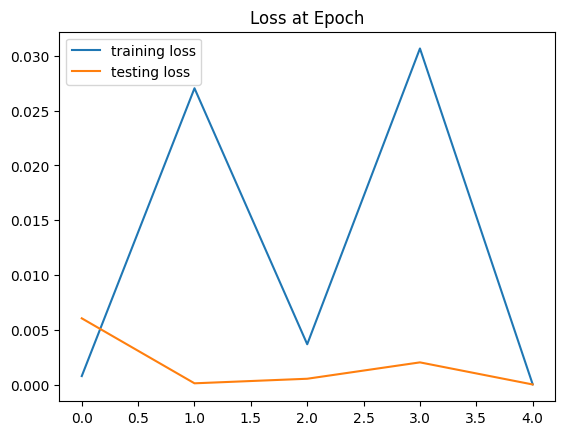

In [35]:
# Graph the loss at epoch
train_losses = [tl.item() for tl in train_losses]
plt.plot(train_losses, label = 'training loss')
plt.plot(test_losses, label = 'testing loss')
plt.title("Loss at Epoch")
plt.legend()

plt.title("Loss at Epoch")
plt.legend()

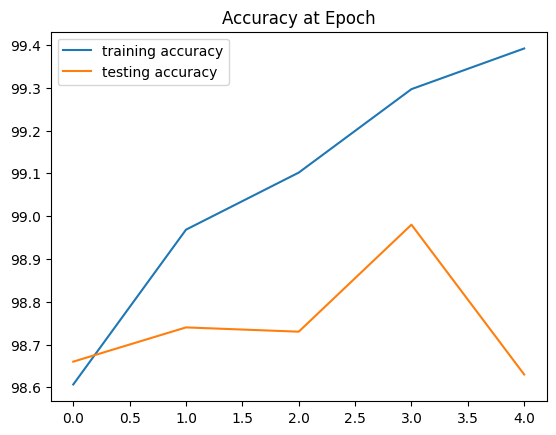

In [41]:
# graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label = 'training accuracy')
plt.plot([t/100 for t in test_correct], label = 'testing accuracy')
plt.title("Accuracy at Epoch")
plt.legend()

In [37]:
# Correct percentage
test_load_everything = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
  correct = 0
  for batch, (X_test, y_test) in enumerate(test_load_everything):
    y_pred = model(X_test)
    predicted = torch.max(y_pred.data, 1)[1]
    correct += (predicted ==y_test).sum()

correct.item()/len(test_data)*100

98.63

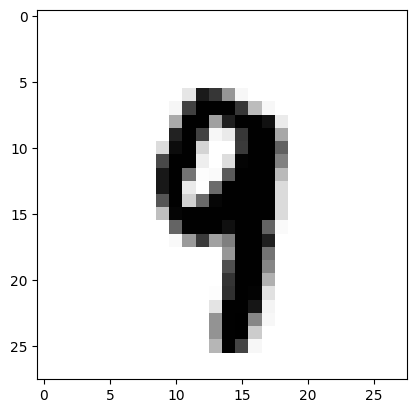

In [38]:
# Send new image thru the model
test_data[4143] # tensor
# Grab just the data
test_data[4143][0]
test_data[4143][0].reshape(28,28)

# show the image
plt.imshow(test_data[4143][0].reshape(28,28), cmap='Greys')

In [39]:
# Pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28)) #batch size of 1, 1 color channel

# Get probabilities of all numbers
new_prediction

# Get the predicted number : the biggest p of numbers
new_prediction.argmax()

tensor(9)